# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission, if necessary. Sections that begin with **'Implementation'** in the header indicate where you should begin your implementation for your project. Note that some sections of implementation are optional, and will be marked with **'Optional'** in the header.

In addition to implementing code, there will be questions that you must answer which relate to the project and your implementation. Each section where you will answer a question is preceded by a **'Question'** header. Carefully read each question and provide thorough answers in the following text boxes that begin with **'Answer:'**. Your project submission will be evaluated based on your answers to each of the questions and the implementation you provide.

>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import cv2
import tensorflow as tf
from tensorflow.contrib.layers import flatten
import numpy as np
import matplotlib.pyplot as plt
import csv
from textwrap import fill
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from collections import defaultdict
from datetime import datetime
import os

In [2]:
# Load pickled data
import pickle

# Fill this in based on where you saved the training and testing data

training_file = 'traffic-signs-data/train.p'
testing_file = 'traffic-signs-data/test.p'

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)
    
X_train, y_train = train['features'], train['labels']
X_test, y_test = test['features'], test['labels']

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 2D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below.

In [3]:
### Replace each question mark with the appropriate value.

# Number of training examples
n_train = len(X_train)
n_train_y = len(y_train)

assert n_train == n_train_y, 'Different numbers of training examples and labels'

# Number of testing examples.
n_test = len(X_test)
n_test_y = len(y_test)

assert n_test == n_test_y, 'Different numbers of testing examples and labels'

# What's the shape of an traffic sign image?
image_shape = X_train[0].shape

# How many unique classes/labels there are in the dataset.
n_classes = len(np.unique(y_test))

print("Number of training examples =", n_train)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("Image data type =", X_train[0].dtype)

Number of training examples = 39209
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
Image data type = uint8


Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc.

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections.

In [4]:
### Data exploration visualization goes here.
### Feel free to use as many code cells as needed.

# Visualizations will be shown in the notebook.
%matplotlib inline

# A mapping from class id to class name from the csv file
class_name = {}

with open('signnames.csv', 'r') as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        class_name.update({int(row['ClassId']): row['SignName']})

# Plotting samples from a dataset
def plot_samples(X, y=None):
    for e, index in enumerate(np.random.choice(range(len(X)), size=6)):
        plt.subplot(2, 3, e+1)
        if X.shape[-1] == 3:
            plt.imshow(X[index])
        else:
            plt.imshow(X[index, :, :, 0], cmap='gray')
        if len(y) > 0:
            plt.title(fill("{}: {}".format(y[index], class_name[y[index]]), 35))
    plt.tight_layout(rect=[0, 0, 1.7, 1.7])
    plt.show()

# Plotting distrubution of classes in a dataset
def classes_distribution(y):
    plt.hist(y, bins=43)
    plt.grid(True)
    plt.xlabel('Class ID')
    plt.ylabel('Class count')
    plt.show()

### Samples from the training dataset

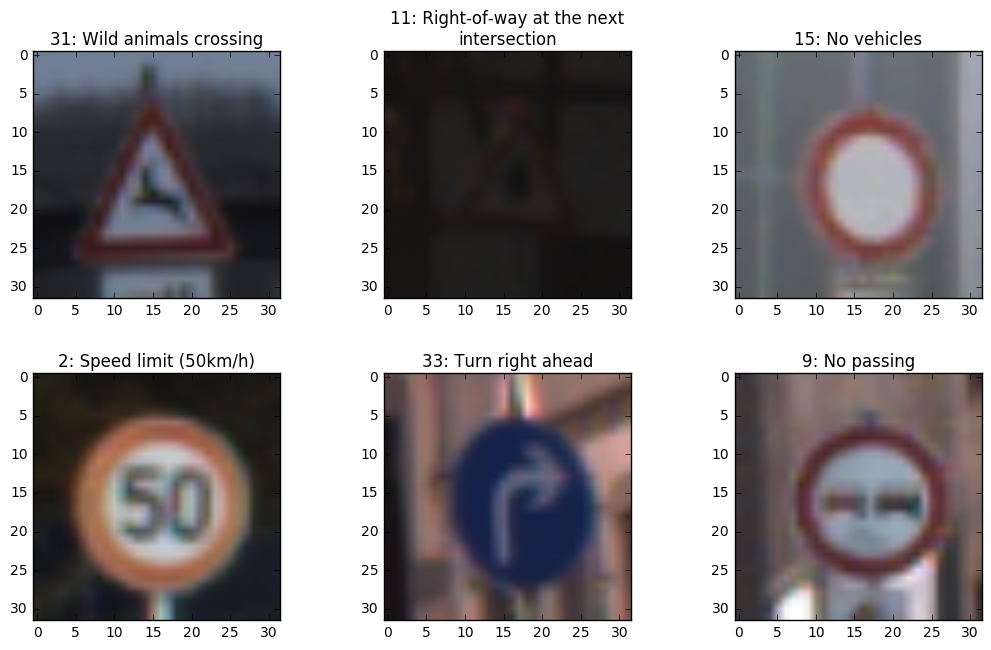

In [5]:
# Examples from the training dataset
plot_samples(X_train, y_train)

### Samples from the testing dataset

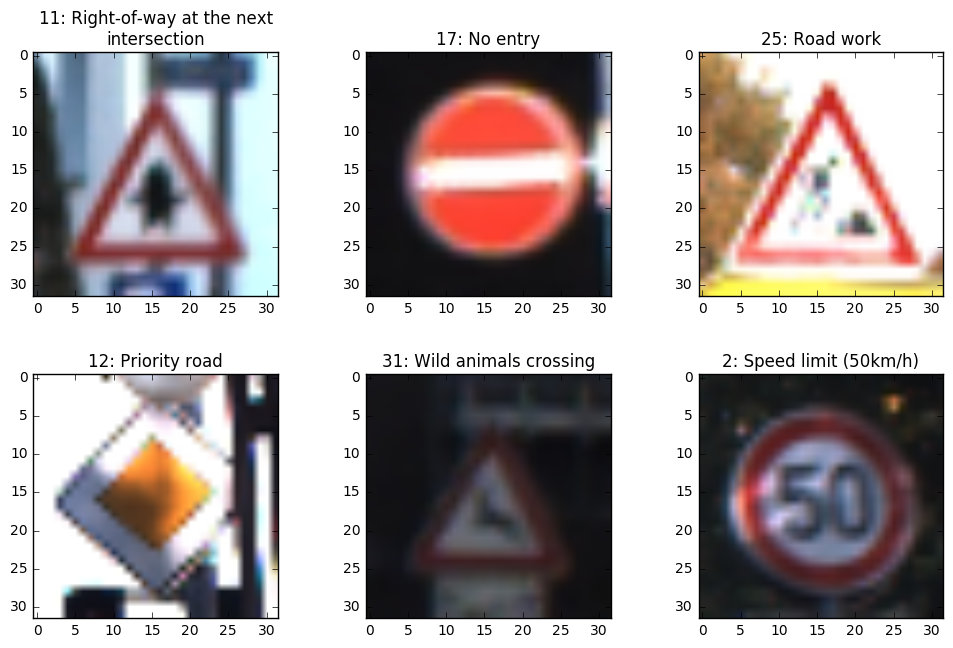

In [6]:
# Examples from the testing dataset
plot_samples(X_test, y_test)

### Distribution of classes in the training dataset

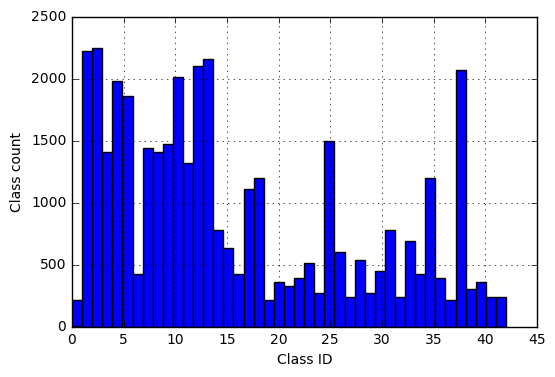

In [7]:
classes_distribution(y_train)

### Distribution of classes in the testing dataset

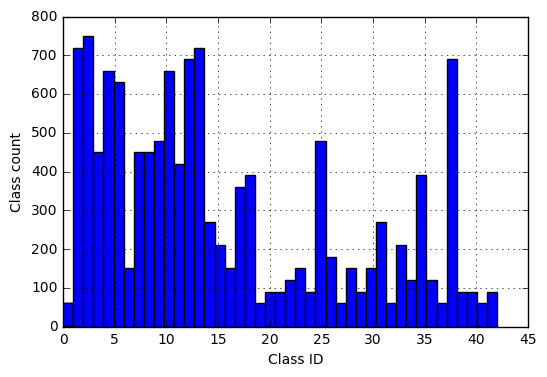

In [8]:
classes_distribution(y_test)

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

There are various aspects to consider when thinking about this problem:

- Neural network architecture
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

**NOTE:** The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play!

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [9]:
### Preprocess the data here.
### Feel free to use as many code cells as needed.

def change_type_to_float32(x):
    return x.astype(np.float32)

# Convert to grayscale
def grayscale(x):
    x_gray = np.zeros([x.shape[0], 32, 32, 1], dtype=np.uint8)
    for i in range(len(x)):
        x_gray[i, :, :, 0] = cv2.cvtColor(x[i], cv2.COLOR_BGR2GRAY)
    return x_gray

def minmax_scale(x, a, b):
    for sample in range(x.shape[0]):
        img_min = x[sample].min()
        img_max = x[sample].max()
        x[sample] = a + (x[sample] - img_min) * (b - a) / (img_max - img_min)
    return x

def contrast_limited_normalize(x):
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(3, 3))
    for sample in range(x.shape[0]):
        x[sample, :, :, 0] = clahe.apply(x[sample, :, :, 0])
    return x

def data_summary(name, x):
    print("{} data summary:".format(name))
    print("Shape =", x.shape)
    print("Data type =", x.dtype)
    print("Min =", x.min())
    print("Max =", x.max())
    print()

In [10]:
# Convert to grayscale
X_train = grayscale(X_train)
X_test = grayscale(X_test)

In [11]:
# Equalize histogram with local constrast constraint
X_train = contrast_limited_normalize(X_train)
X_test = contrast_limited_normalize(X_test)

In [12]:
# Change type to float32
X_train = change_type_to_float32(X_train)
X_test = change_type_to_float32(X_test)

In [13]:
# Rescale each image to the range -0.9 - 0.9
a, b = -0.9, 0.9
X_train = minmax_scale(X_train, a, b)
X_test = minmax_scale(X_test, a, b)

In [14]:
# Check preprocessed data properties
data_summary("Training", X_train)
data_summary("Testing", X_test)

Training data summary:
Shape = (39209, 32, 32, 1)
Data type = float32
Min = -0.9
Max = 0.9

Testing data summary:
Shape = (12630, 32, 32, 1)
Data type = float32
Min = -0.9
Max = 0.9



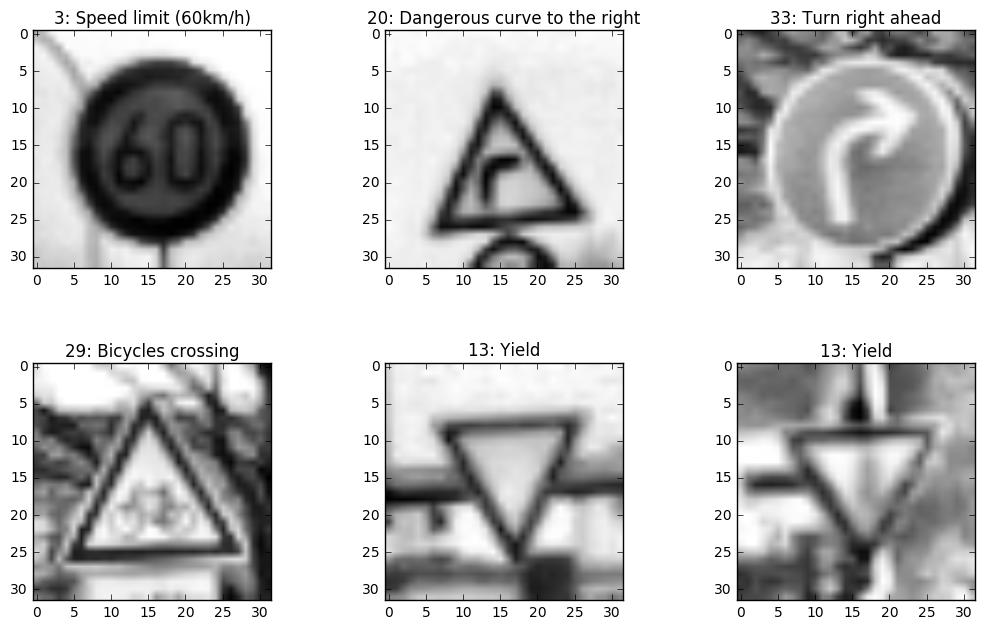

In [15]:
# Check training data
plot_samples(X_train, y_train)

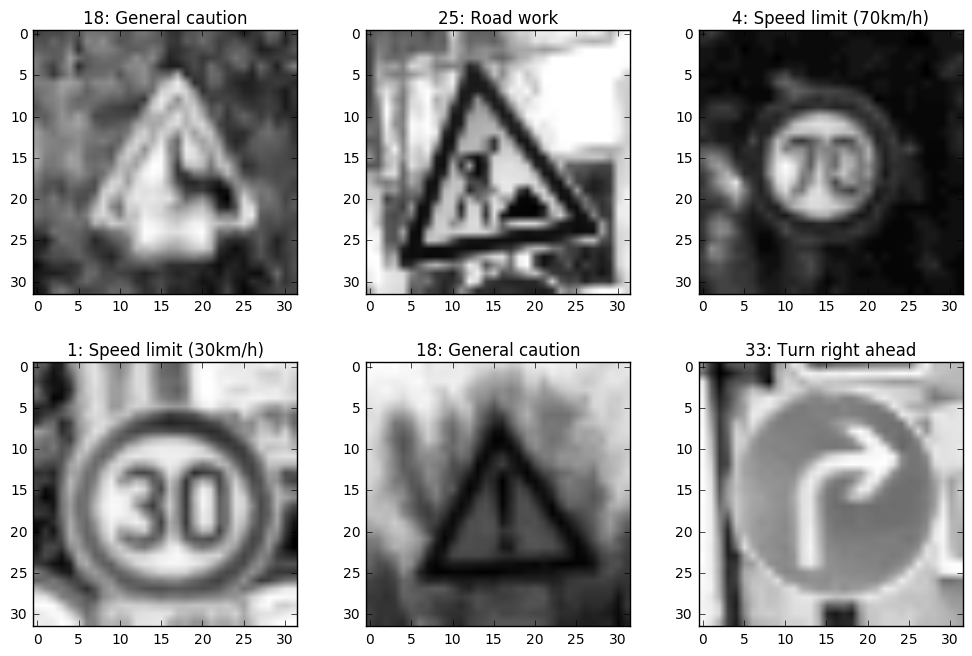

In [16]:
# Check testing data
plot_samples(X_test, y_test)

### Question 1 

_Describe how you preprocessed the data. Why did you choose that technique?_

**Answer:** The original data consists of color images (3 channels) with uint8 (0 - 255) data type. According to the published baseline model, grayscale images yield higher accuracies for this problem, so we choose that as the first transformation in our preprocessing pipeline. Then we apply a constrast limited adaptive histogram equalization to enhance images with bright spots. The goal is to improve traffic signs contrast despite of other regions with high intensity pixels. Then we change the image data type to float32 and map pixel values to the range -0.9 to 0.9, so the first convolutional layer has a uniform input.

In [17]:
### Generate data additional data (OPTIONAL!)
### and split the data into training/validation/testing sets here.
### Feel free to use as many code cells as needed.

In [18]:
# Define image transformations
# Translation
def random_shift(img):
    rows, cols = img.shape[0], img.shape[1]
    deltax = np.random.randint(-2, 3)
    deltay = np.random.randint(-2, 3)
    
    #Translation matrix
    TM = np.float32([[1, 0, deltax], [0, 1, deltay]])
    return cv2.warpAffine(img, TM, (cols, rows))

# Rotation
def random_rotation(img):
    rows, cols = img.shape[0], img.shape[1]
    angle = np.random.randint(-10, 11)
    
    # Rotation matrix
    RM = cv2.getRotationMatrix2D((cols/2, rows/2), angle, 1)
    return cv2.warpAffine(img, RM, (cols, rows))

# Define data augmentation function
def augment_data(X, y, additional_datasets=4):
    new_X = X.copy()
    new_y = y.copy()
    for i in range(additional_datasets):
        for sample in range(new_X.shape[0]):
            new_X[sample, :, :, 0] = random_shift(random_rotation(new_X[sample]))
        X = np.concatenate((X, new_X.copy()))
        y = np.concatenate((y, new_y.copy()))
    return X, y

In [19]:
# Augment data and shuffle result
if not os.path.exists('augmented.p'):
    X_train, y_train = augment_data(X_train, y_train)

    for _ in range(3):
        X_train, y_train = shuffle(X_train, y_train)
    
    with open('augmented.p', 'wb') as f:
        pickle.dump({'X_train': X_train, 'y_train': y_train}, f)
else:
    with open('augmented.p', 'rb') as f:
        data = pickle.load(f)
        X_train, y_train = data['X_train'], data['y_train']

In [20]:
# Split data. train_test_split already takes care of the shuffling
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, train_size=0.8, random_state=42)

In [21]:
data_summary("Training features", X_train)
data_summary("Training labels", y_train)
data_summary("Validation features", X_validation)
data_summary("Validation labels", y_validation)

Training features data summary:
Shape = (156836, 32, 32, 1)
Data type = float32
Min = -0.9
Max = 0.9

Training labels data summary:
Shape = (156836,)
Data type = uint8
Min = 0
Max = 42

Validation features data summary:
Shape = (39209, 32, 32, 1)
Data type = float32
Min = -0.9
Max = 0.9

Validation labels data summary:
Shape = (39209,)
Data type = uint8
Min = 0
Max = 42



### Question 2

_Describe how you set up the training, validation and testing data for your model. **Optional**: If you generated additional data, how did you generate the data? Why did you generate the data? What are the differences in the new dataset (with generated data) from the original dataset?_

**Answer:** We've generated 4 additional datasets by randomly shifting and rotating images from the original dataset. The images were shifted by -2 to 2 pixels in both width and height, and rotated by -10 to +10 degrees. The final dataset was then shuffled.

Additional data was generated because it usually improves convnets performance and in this case helps to solve the problem of having few examples of some classes. By copying, transforming and merging the original dataset we keep the proportion of train/test examples for each class, although some classes still have more samples than others.

The testing data wasn't changed, while the training and validation datasets were obtained from the augmented training dataset: 80% for the new training dataset and 20% for validation.

In [22]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

EPOCHS = 100
BATCH_SIZE = 128

def LeNet(x, keep_prob):    
    # Hyperparameters
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x1. Output = 28x28x50.
    C1_W = tf.Variable(tf.truncated_normal([5, 5, 1, 50], mean=mu, stddev=sigma))
    C1_b = tf.Variable(tf.zeros([50]))
    conv1 = tf.nn.conv2d(x, C1_W, strides=[1, 1, 1, 1], padding='VALID') + C1_b

    # Activation. Output = 28x28x5.
    actv1 = tf.nn.relu(conv1)
    
    # Layer 2: Convolutional. Input = 28x28x50. Output = 24x24x100
    C2_W = tf.Variable(tf.truncated_normal([5, 5, 50, 100], mean=mu, stddev=sigma))
    C2_b = tf.Variable(tf.zeros([100]))
    conv2 = tf.nn.conv2d(actv1, C2_W, strides=[1, 1, 1, 1], padding='VALID') + C2_b

    # Activation. Output = 24x24x10.
    actv2 = tf.nn.relu(conv2)
    
    # Pooling. Input = 24x24x10. Output = 12x12x10.
    pool2nd = tf.nn.max_pool(actv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Pooling. Input = 28x28x5. Output = 14x14x5.
    pool1st = tf.nn.max_pool(actv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    
    # Flatten. Input = 14x14x5. Output = 980.
    flat1 = flatten(pool1st)
    
    # Flatten. Input = 12x12x10. Output = 1440.
    flat2 = flatten(pool2nd)
    
    # Concatenation. Output = 24200.
    flat = tf.concat_v2([flat1, flat2], axis=1)
    
    # Layer 3: Fully Connected. Input = 24200. Output = 100.
    FC1_W = tf.Variable(tf.truncated_normal([24200, 100], mean=mu, stddev=sigma))
    FC1_b = tf.Variable(tf.zeros([100]))
    FC1_out = tf.add(tf.matmul(flat, FC1_W), FC1_b)
    
    # Activation.
    actv3 = tf.nn.relu(FC1_out)
    
    dropout1 = tf.nn.dropout(actv3, keep_prob=keep_prob)

    # Layer 4: Fully Connected. Input = 100. Output = 100.
    FC2_W = tf.Variable(tf.truncated_normal([100, 100], mean=mu, stddev=sigma))
    FC2_b = tf.Variable(tf.zeros([100]))
    FC2_out = tf.add(tf.matmul(dropout1, FC2_W), FC2_b)
    
    # Activation.
    actv4 = tf.nn.relu(FC2_out)
    
    dropout2 = tf.nn.dropout(actv4, keep_prob=keep_prob)

    # Layer 5: Fully Connected. Input = 100. Output = 43.
    FC3_W = tf.Variable(tf.truncated_normal([100, 43], mean=mu, stddev=sigma))
    FC3_b = tf.Variable(tf.zeros([43]))
    logits = tf.add(tf.matmul(dropout2, FC3_W), FC3_b)
    
    return logits

In [23]:
x = tf.placeholder(tf.float32, (None, 32, 32, 1))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43)

In [24]:
learning_rate = 0.001

logits = LeNet(x, keep_prob)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(logits, one_hot_y)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
training_operation = optimizer.minimize(loss_operation)

In [25]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data, kp):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: kp})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

### Question 3

_What does your final architecture look like? (Type of model, layers, sizes, connectivity, etc.)  For reference on how to build a deep neural network using TensorFlow, see [Deep Neural Network in TensorFlow
](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/b516a270-8600-4f93-a0a3-20dfeabe5da6/concepts/83a3a2a2-a9bd-4b7b-95b0-eb924ab14432) from the classroom._


**Answer:** We used a convolutional neural network followed by a fully connected network with 2 hidden layers. The first convolutional layer has 50 5x5 output filters with unitary stride in all dimensions. This layer is followed by an activation layer of rectified linear units. The second convolutional layer has 100 5x5 output filters with unitary stride in all dimensions and is followed by the same kind of activation layer. The ouputs of both first and second layer activations are 'max-pooled' with a 2x2 kernel size and 2x2 stride in width and height, flattened, concatenated and fed into the first fully connected hidden layer, which has 100 output neurons. The second fully connected hidden layer also has 100 outputs and the output layer has 43 logits. Each fully connected hidden layer is followed by a rectified linear unit and a dropout layer with an tunable keep probability.

The loss is calculated using the cross entropy between the logits distribution, obtained by softmax, and the one hot encoded class label.

In [26]:
### Train your model here.
### Feel free to use as many code cells as needed.

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    num_examples = len(X_train)
    
    start_time = datetime.utcnow()
    print("Training started at {}".format(start_time))
    print("Training...")
    print()
    for i in range(EPOCHS):
        X_train, y_train = shuffle(X_train, y_train)
        for offset in range(0, num_examples, BATCH_SIZE):
            end = offset + BATCH_SIZE
            batch_x, batch_y = X_train[offset:end], y_train[offset:end]
            sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})
            
        validation_accuracy = evaluate(X_validation, y_validation, 1.0)
        print("EPOCH {} ...".format(i+1))
        print("Validation Accuracy = {:.3f}".format(validation_accuracy))
        print()
    
    end_time = datetime.utcnow()
    print("Training finished at {}".format(end_time))
    print("Total training time: {}".format(end_time - start_time))
    
    saver.save(sess, 'traffic-sign-classifier')
    print("Model saved")

Training started at 2017-01-17 22:09:00.753709
Training...

EPOCH 1 ...
Validation Accuracy = 0.841

EPOCH 2 ...
Validation Accuracy = 0.911

EPOCH 3 ...
Validation Accuracy = 0.940

EPOCH 4 ...
Validation Accuracy = 0.955

EPOCH 5 ...
Validation Accuracy = 0.967

EPOCH 6 ...
Validation Accuracy = 0.967

EPOCH 7 ...
Validation Accuracy = 0.973

EPOCH 8 ...
Validation Accuracy = 0.975

EPOCH 9 ...
Validation Accuracy = 0.975

EPOCH 10 ...
Validation Accuracy = 0.979

EPOCH 11 ...
Validation Accuracy = 0.979

EPOCH 12 ...
Validation Accuracy = 0.980

EPOCH 13 ...
Validation Accuracy = 0.981

EPOCH 14 ...
Validation Accuracy = 0.983

EPOCH 15 ...
Validation Accuracy = 0.982

EPOCH 16 ...
Validation Accuracy = 0.983

EPOCH 17 ...
Validation Accuracy = 0.984

EPOCH 18 ...
Validation Accuracy = 0.984

EPOCH 19 ...
Validation Accuracy = 0.984

EPOCH 20 ...
Validation Accuracy = 0.987

EPOCH 21 ...
Validation Accuracy = 0.986

EPOCH 22 ...
Validation Accuracy = 0.987

EPOCH 23 ...
Validation A

In [27]:
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))

    test_accuracy = evaluate(X_test, y_test, 1.0)
    print("Test Accuracy = {:.3f}".format(test_accuracy))

Test Accuracy = 0.981


### Question 4

_How did you train your model? (Type of optimizer, batch size, epochs, hyperparameters, etc.)_


**Answer:** An Adam optimizer was used with a constant learning rate. As stated in its reference paper, this optimizer is efficient, works well with large datasets and many parameters and its hyperparameters have intuitive interpretations and typically require little tuning. In fact, the default hyperparameters were used. Good results were obtained with a batch size of 128 and 100 training epochs. Best test results were obtained with a keep probability of 0.7 for both dropout layers after several experiments.

### Question 5


_What approach did you take in coming up with a solution to this problem? It may have been a process of trial and error, in which case, outline the steps you took to get to the final solution and why you chose those steps. Perhaps your solution involved an already well known implementation or architecture. In this case, discuss why you think this is suitable for the current problem._

**Answer:** The LeNet architecture with a single dropout layer was used as a first approach to this problem, yielding test accuracies of about 92%. Then, based on the paper of Sermanet and LeCun (http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf) we implemented layer skipping, feeding both first and second stage features to the classifier, and grayscale conversion. The depth of the convolutional filters was also increased as suggested in this paper. Based on the paper of Ciresan, Meier and Schmidhuber (https://arxiv.org/abs/1202.2745) contrast limited adaptive histogram equalization was included as a preprocessing step, allowing a small improvement on test accuracy.

As in the digit recognition task, this problem involves the extraction of features with different levels of abstraction. This tells us why the LeNet architecture is suitable for the problem out-of-the-box. Traffic signs show exactly this pattern: they usually consist of an outer shape (circle, triangle, ...) and an inner symbol. This composition may also explain why the use of first and second stage features enhances performance: both the outer shape and the inner symbol are important for a successful classification.

Sigmoid, rectified linear units and hyperbolic tangent activation functions were tried, with relu yielding the best testing accuracies.

The final experiments were performed to tune the keep probability of both dropout layers. A keep probability of 0.7 showed best results. 

---

## Step 3: Test a Model on New Images

Take several pictures of traffic signs that you find on the web or around you (at least five), and run them through your classifier on your computer to produce example results. The classifier might not recognize some local signs but it could prove interesting nonetheless.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Implementation

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project. Once you have completed your implementation and are satisfied with the results, be sure to thoroughly answer the questions that follow.

In [28]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.
def load_images(folder):
    images = np.empty((0, 32, 32, 1))
    for filename in os.listdir(folder):
        if not filename.startswith('.'):
            filepath = os.path.join(folder, filename)
            print("Loading image from {}".format(filepath))
            img = np.zeros((1, 32, 32, 1))
            img[0, :, :, 0] = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
            images = np.concatenate((images, img))

    return images

In [29]:
New_images = load_images('TrafficSignImages')

Loading image from TrafficSignImages/image6.jpg
Loading image from TrafficSignImages/image2.jpg
Loading image from TrafficSignImages/image5.jpg
Loading image from TrafficSignImages/image1.jpg
Loading image from TrafficSignImages/image4.jpg
Loading image from TrafficSignImages/image3.jpg


In [30]:
New_images = change_type_to_float32(New_images)
New_images = minmax_scale(New_images, a, b)

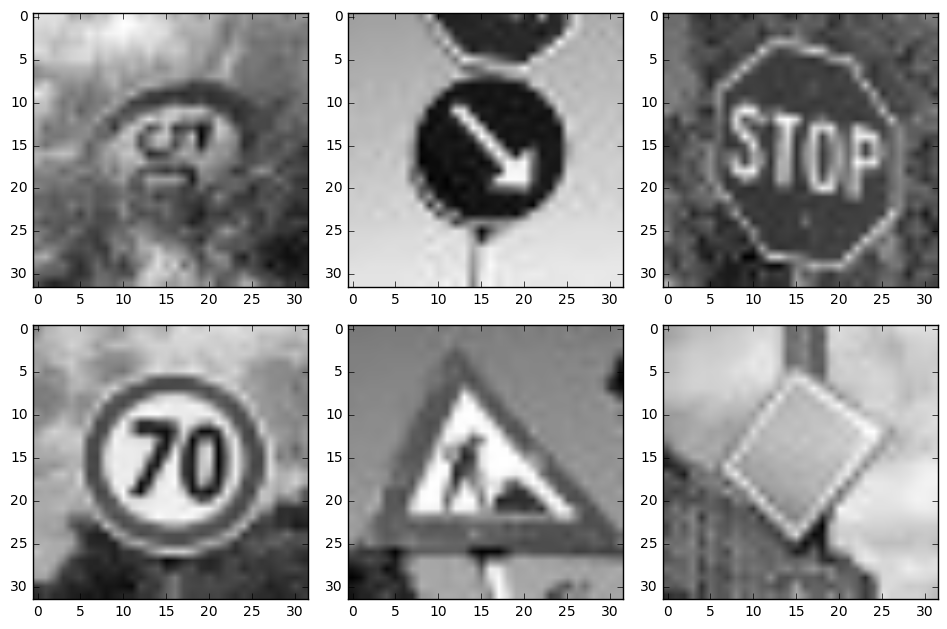

In [31]:
num_new_img = len(New_images)
for i in range(num_new_img):
    plt.subplot(2, 3, i+1)
    plt.imshow(New_images[i, :, :, 0], cmap='gray')
plt.tight_layout(rect=[0, 0, 1.6, 1.6])
plt.show()

### Question 6

_Choose five candidate images of traffic signs and provide them in the report. Are there any particular qualities of the image(s) that might make classification difficult? It could be helpful to plot the images in the notebook._



**Answer:** We made 6 predictions and 5 of them were correct. The incorrect prediction corresponds to a fallen traffic sign partially covered by grass. Interestingly, the neural network identified a speed limit sign but guessed the limit itself incorrectly. Therefore that was a particularly difficult image, since it is also rotated by 90 degrees, much more than the small rotations we applied during data augmentation. Other images may be difficult because of their skewed angle of view, usually not present in the training dataset.

In [32]:
### Run the predictions here.
### Feel free to use as many code cells as needed.
predicted_ids = None
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicted_ids = sess.run(tf.argmax(logits, 1), feed_dict={x: New_images, keep_prob: 1.0})

### Preditions

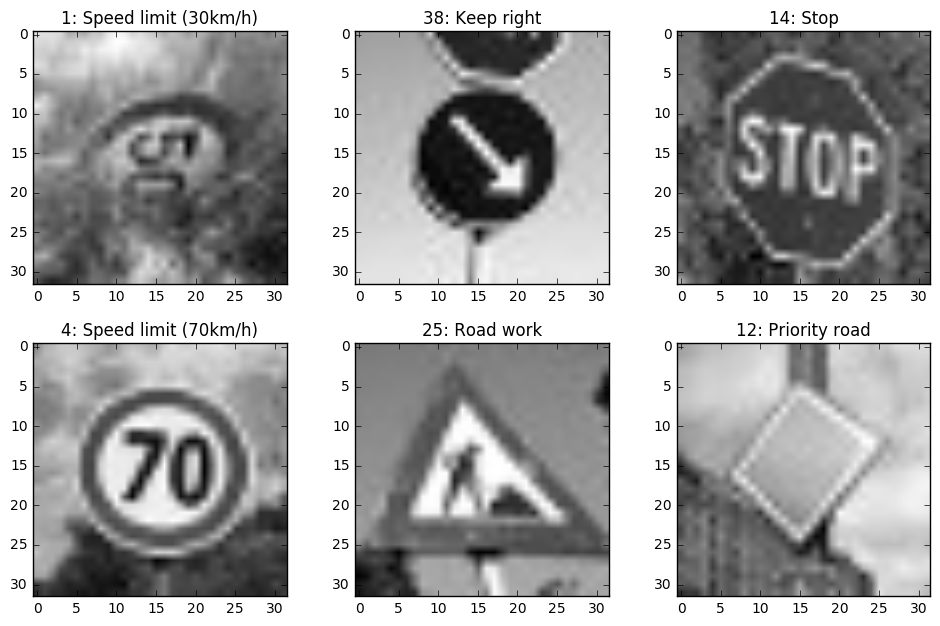

In [33]:
for i, pred_id in enumerate(predicted_ids):
    plt.subplot(2, 3, i+1)
    plt.imshow(New_images[i, :, :, 0], cmap='gray')
    plt.title(fill("{}: {}".format(pred_id, class_name[pred_id], 35)))
plt.tight_layout(rect=[0, 0, 1.6, 1.6])
plt.show()

### Question 7

_Is your model able to perform equally well on captured pictures when compared to testing on the dataset? The simplest way to do this check the accuracy of the predictions. For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate._

_**NOTE:** You could check the accuracy manually by using `signnames.csv` (same directory). This file has a mapping from the class id (0-42) to the corresponding sign name. So, you could take the class id the model outputs, lookup the name in `signnames.csv` and see if it matches the sign from the image._


**Answer:** The model is quite accurate since it correctly predicted 5 out of 6 (~83%) traffic signs and the wrong prediction corresponds to a particularly challenging image, one which is much more rotated than the images in the training dataset and is partially occluded.

In [34]:
### Visualize the softmax probabilities here.
### Feel free to use as many code cells as needed.
predicted_prob = None
top_5 = None
with tf.Session() as sess:
    saver.restore(sess, tf.train.latest_checkpoint('.'))
    predicted_prob = sess.run(tf.nn.softmax(logits), feed_dict={x: New_images, keep_prob: 1.0})
    top_5 = sess.run(tf.nn.top_k(predicted_prob, k=5, sorted=True))

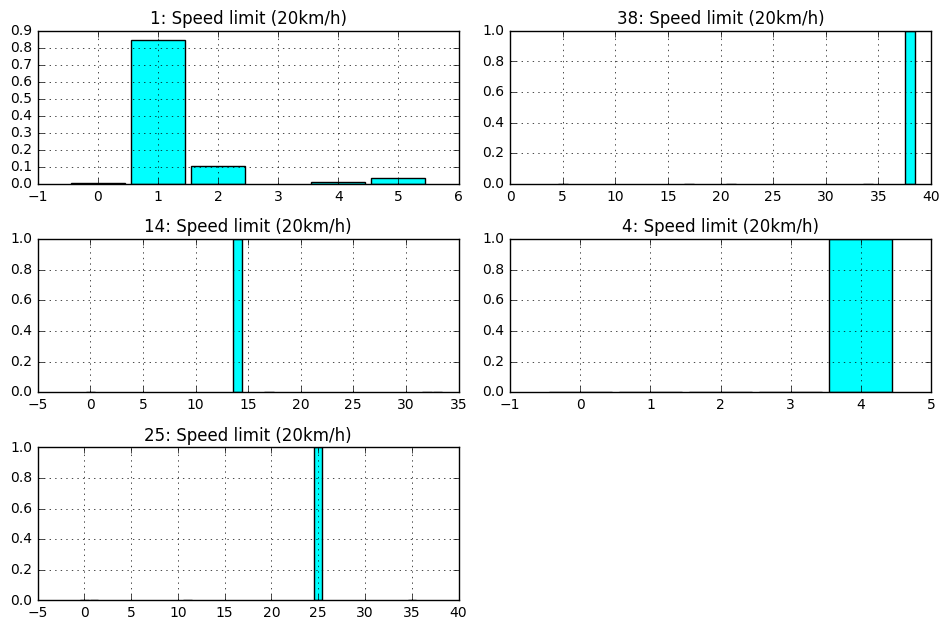

In [35]:
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.bar(top_5.indices[i], top_5.values[i], width=.9, align='center', color='cyan')
    plt.grid(True)
    plt.xticks = top_5.indices[i]
    max_prob_idx = np.argmax(top_5.values[i])
    plt.title(fill("{}: {}".format(top_5.indices[i][max_prob_idx], class_name[max_prob_idx], 35)))
plt.tight_layout(rect=[0, 0, 1.6, 1.6])
plt.show()

### Question 8

*Use the model's softmax probabilities to visualize the **certainty** of its predictions, [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. Which predictions is the model certain of? Uncertain? If the model was incorrect in its initial prediction, does the correct prediction appear in the top k? (k should be 5 at most)*

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

**Answer:** Looking at the plots above we can see that the model is quite certain of its predictions, except for the first and more challenging image, for which there is an alternative prediction with about 10% probability. Interestingly, that is the correct prediction. For the other images, the probability is clearly concentrated in a single class.

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.